* Import importent stuff. 
* pay attention: **%matplotlib notebook** isn't working in **Jupyter lab**, only in **Jupyter notebook**
* It allow Interactive matplotlib GUI, therefore **Jupyter notebook** is very recommended

In [15]:
import cv2
import os
from functions import plot_samples,calc_depth_grads, plot_samples_grads
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import preprocessing as prp
np.set_printoptions(threshold=sys.maxsize)
%matplotlib notebook

* define working directories (excluded from the git - see .gitignore)

In [12]:
depth_dir = 'data/nyuv2/depth'
rgb_dir   = 'data/nyuv2/rgb'
pwd = os.getcwd()
depth_dir = os.path.join(pwd,depth_dir)
rgb_dir   = os.path.join(pwd,rgb_dir)

* pick samles randomly for testing

In [13]:
depth_fnames = os.listdir(depth_dir)
depth_fnames.sort()

depth_abs_fnames = [os.path.join(depth_dir,f) for f in depth_fnames]
rgb_abs_fnames   = [os.path.join(rgb_dir,f) for f in depth_fnames]

samples_idx   = np.random.choice(len(depth_abs_fnames), 4)
depth_samples = [depth_fnames[i] for i in samples_idx]
depth_samples

['517.png', '1171.png', '957.png', '163.png']

* Show the samples (rgb & rgbd)

<IPython.core.display.Javascript object>


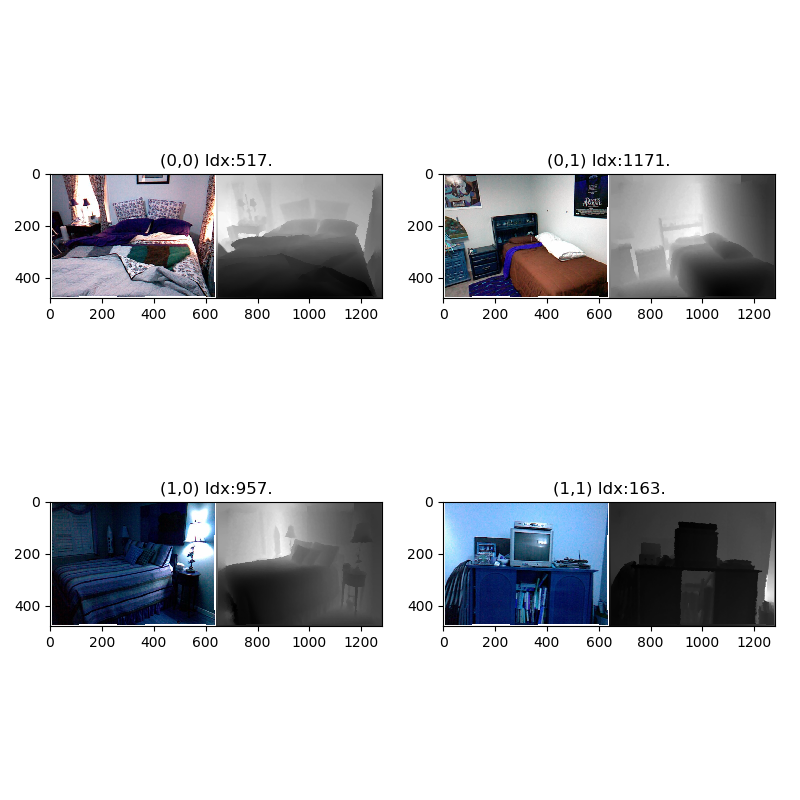

In [23]:
plot_samples(samples_fnames=depth_samples, depth_dir=depth_dir,rgb_dir=rgb_dir,figsize=(8,8))

* First, let's define a simple test image to check out approaches.
    * first approach: Gradient of the depth map using Soble & Scharr filters
    * second approach: pixel-wise difference calculation

* Our test image include 4 typical cases for depth direction estimation:
    * Closer object on farther background (upper left). for example: an obstacle
    * Farther object surrounded by closer area (bottom right). for example: a window / a door
    * A bold frame (upper right)
    * A sinked frame (bottom left)

In [24]:
test_img = np.ones((30,30))

test_img[3:8,3:8] = 0     # closer than background object (an obstacle for instance)
test_img[20:26,20:26] = 2 # farther than it surroundings object (a door, a window) 

test_img[3:11, 18:26] = 0 # a closer frame
test_img[6:8, 21:23]  = 1

test_img[18:26,3:11] = 2 # a farther frame
test_img[20:24,5:9]  = 1


grad_x = cv2.Sobel(test_img,cv2.CV_64F,1,0,ksize=-1)
grad_y = cv2.Sobel(test_img,cv2.CV_64F,0,1,ksize=-1)

* Normalize the gradients to range [-1,1]
* Note that in ordr to preserve directionality, we don't want Min-Max normalization as usual (becauser then the range is [0,1])

In [25]:
grad_x = 2*((grad_x-np.min(grad_x))/(np.max(grad_x)-np.min(grad_x)))-1
grad_y = 2*((grad_y-np.min(grad_y))/(np.max(grad_y)-np.min(grad_y)))-1

* Pay attention that because numpy coordination system (origin at the upper-right corner), the quiver is fliped. the arrows orientation is correct.

<IPython.core.display.Javascript object>


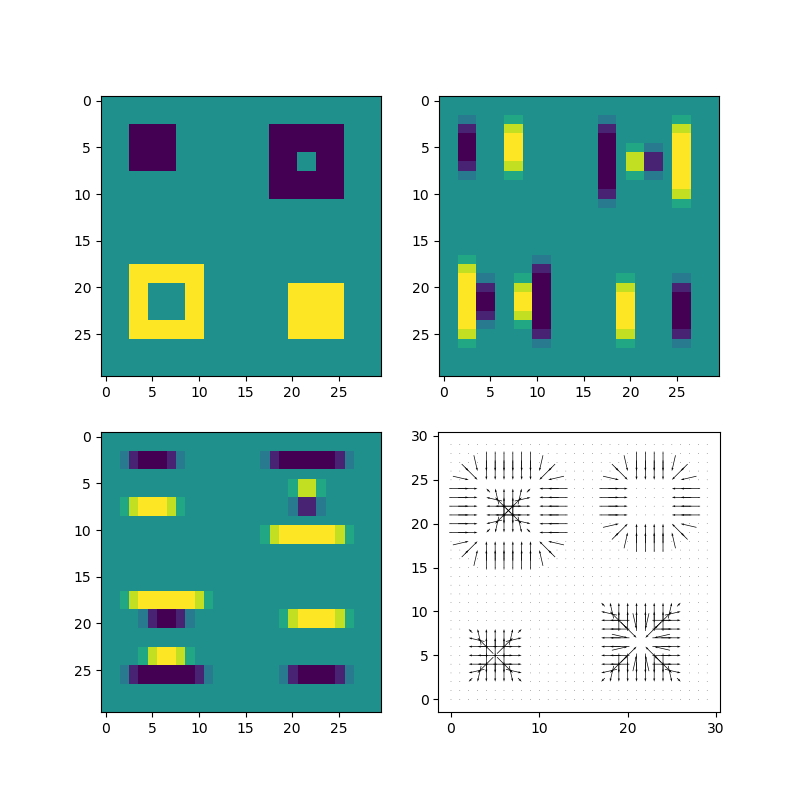

In [26]:
X,Y = np.meshgrid(np.arange(test_img.shape[1]), np.arange(test_img.shape[0]))
U = grad_x
V = grad_y
fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[1,1].quiver(X, Y, U, V, pivot='tip', units='xy')
ax[0,0].imshow(test_img)
ax[0,1].imshow(grad_x)
ax[1,0].imshow(grad_y)
plt.show()

Now let's try it on a real batch of samples from the depth images data-set

In [27]:
def one_one_normalization(data):
    data = 2*((data-np.min(data))/(np.max(data)-np.min(data)))-1
    return data

* We denote 2 kinds of data normalization:
    * each sample i.i.d normalization
    * whole data-set normalization
* After review the following visualizations, I think whole data-set normalization is better representation of the reality

0) 517.png ... done.
1) 1171.png ... done.
2) 957.png ... done.
3) 163.png ... done.
Minus One-One Normalization:
---------------------------
All-Together Normalization ... 
-0) |datax|=(48, 64), |datay|=(48, 64)
-1) |datax|=(96, 64), |datay|=(96, 64)
-2) |datax|=(144, 64), |datay|=(144, 64)
-3) |datax|=(192, 64), |datay|=(192, 64)
Done.


<IPython.core.display.Javascript object>


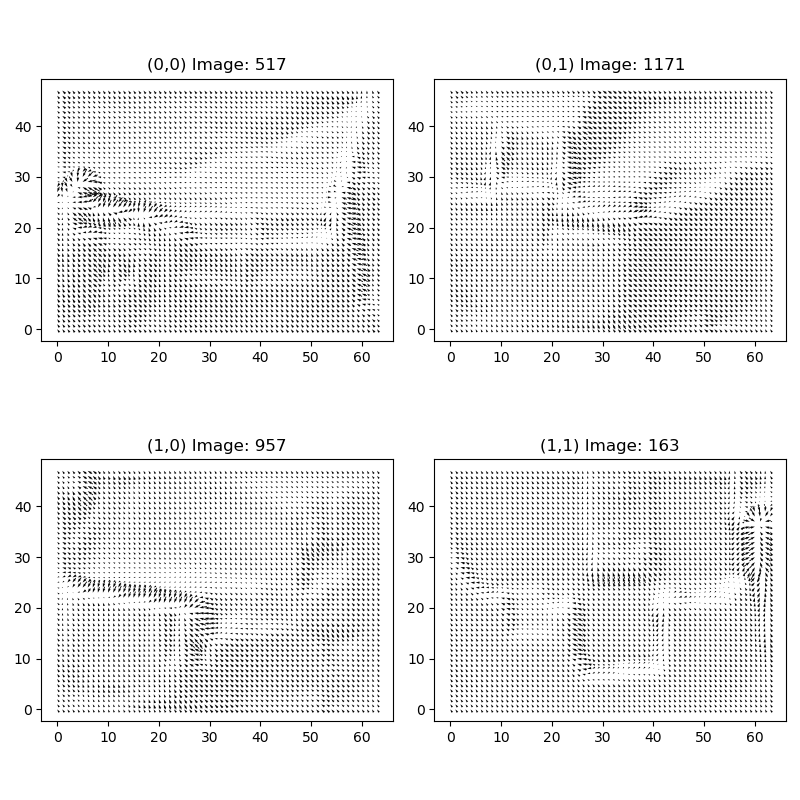

In [28]:
grads = calc_depth_grads(depth_samples,depth_dir, ksize=5, gradient_degree=1, normalization='alltogether')
plot_samples_grads(grads)

0) 517.png ... done.
1) 1171.png ... done.
2) 957.png ... done.
3) 163.png ... done.
Minus One-One Normalization:
---------------------------
Each-One Normalization ... 
Done.


<IPython.core.display.Javascript object>


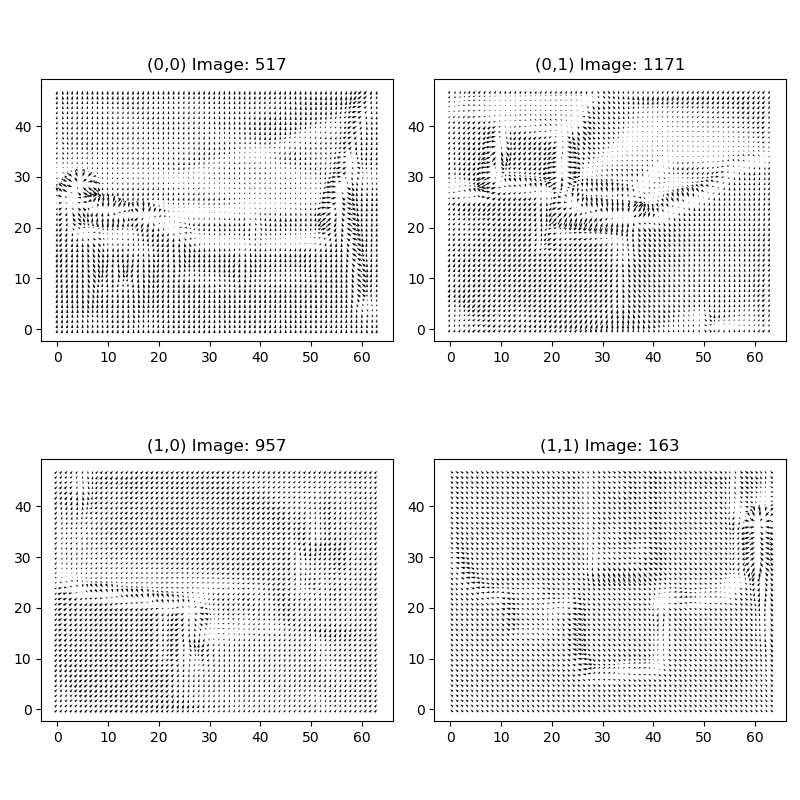

In [29]:
grads = calc_depth_grads(depth_samples,depth_dir, ksize=5, gradient_degree=1, normalization='eachone')
plot_samples_grads(grads)

You can see that the result are not bad at all. of-course there are some artifacts (can be handled maybe by changing the kernel size and/or averaging groups of arrows)